<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

#### <center>К [статье](https://habrahabr.ru/company/ods/blog/323730/) на Хабре "Предсказываем будущее с помощью библиотеки Facebook Prophet"

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd

from plotly import __version__
print(__version__) # need 1.9.0 or greater
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

2.2.1


## Загрузка и предобработка данных
Данные [соревнования](https://inclass.kaggle.com/c/howpop-habrahabr-favs-lognorm) по прогнозу популярности статьи на Хабрахабре.

In [2]:
habr_df = pd.read_csv('../../data/howpop_train.csv')

In [3]:
habr_df['published'] = pd.to_datetime(habr_df.published)
habr_df = habr_df[['published', 'url']]
habr_df = habr_df.drop_duplicates()

In [4]:
aggr_habr_df = habr_df.groupby('published')[['url']].count()
aggr_habr_df.columns = ['posts']

In [5]:
aggr_habr_df = aggr_habr_df.resample('D').apply(sum)
plotly_df(aggr_habr_df.resample('W').apply(sum), 
          title = 'Опубликованные посты на Хабрахабре')

## Построение прогноза Prophet

In [10]:
# pip install pystan
# pip install fbprophet
from fbprophet import Prophet

In [11]:
predictions = 30

df = aggr_habr_df.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
3222,2016-10-27,58.0
3223,2016-10-28,53.0
3224,2016-10-29,14.0
3225,2016-10-30,27.0
3226,2016-10-31,80.0


In [12]:
train_df = df[:-predictions]

In [13]:
m = Prophet()
m.fit(train_df)

In [15]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
3222,2016-10-27
3223,2016-10-28
3224,2016-10-29
3225,2016-10-30
3226,2016-10-31


In [17]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
3222,2016-10-27,57.280862,57.280862,57.280862,53.977245,82.192483,10.759621,10.759621,10.759621,10.759621,10.759621,10.759621,8.474699,8.474699,8.474699,2.284923,2.284923,2.284923,68.040483
3223,2016-10-28,57.279183,57.279174,57.279183,49.802342,78.318219,6.959244,6.959244,6.959244,6.959244,6.959244,6.959244,4.653820,4.653820,4.653820,2.305424,2.305424,2.305424,64.238427
3224,2016-10-29,57.277505,57.275535,57.277505,22.128468,51.390762,-21.019174,-21.019174,-21.019174,-21.019174,-21.019174,-21.019174,-23.329151,-23.329151,-23.329151,2.309977,2.309977,2.309977,36.258332
3225,2016-10-30,57.275827,57.270618,57.275827,23.829824,53.057499,-18.596397,-18.596397,-18.596397,-18.596397,-18.596397,-18.596397,-20.895560,-20.895560,-20.895560,2.299162,2.299162,2.299162,38.679430
3226,2016-10-31,57.274149,57.265012,57.274149,54.910459,83.309566,11.861995,11.861995,11.861995,11.861995,11.861995,11.861995,9.588088,9.588088,9.588088,2.273908,2.273908,2.273908,69.136144


In [18]:
print(', '.join(forecast.columns))

ds, trend, trend_lower, trend_upper, yhat_lower, yhat_upper, seasonal, seasonal_lower, seasonal_upper, seasonalities, seasonalities_lower, seasonalities_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, yhat


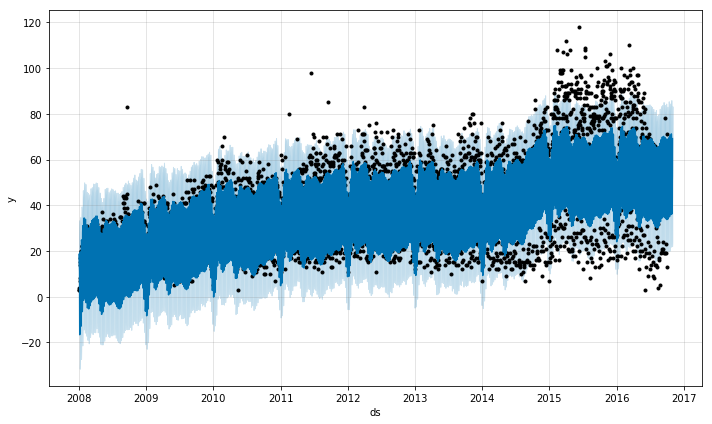

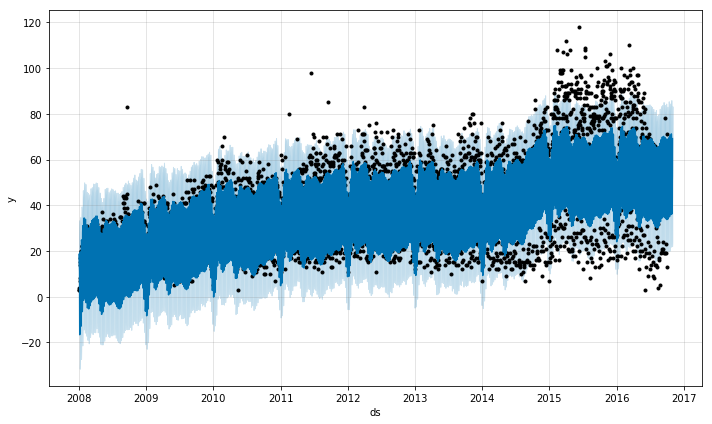

In [19]:
m.plot(forecast)

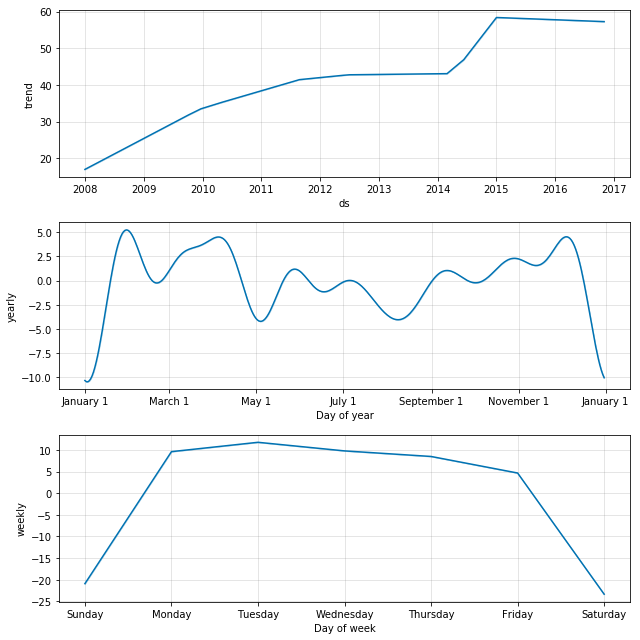

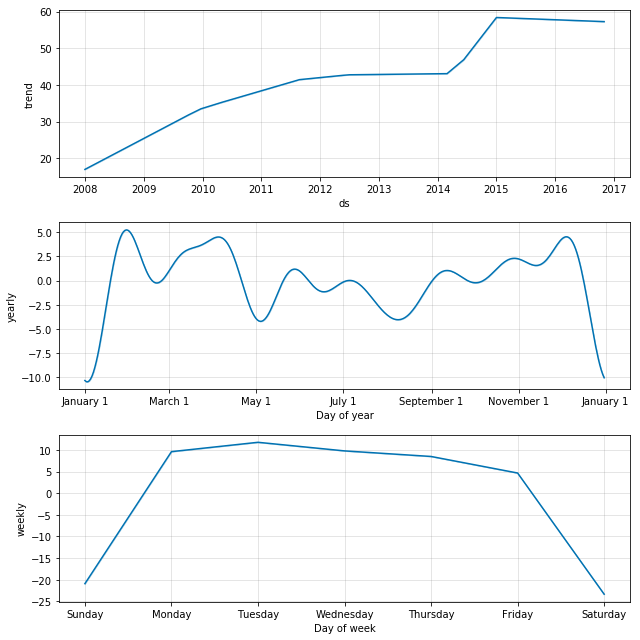

In [20]:
m.plot_components(forecast)

## Оценка качества Prophet

In [22]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [23]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
np.mean(abs(cmp_df[-predictions:]['p'])), np.mean(abs(cmp_df[-predictions:]['e']))

(38.912082831689055, 11.074589637597075)

## Прогноз с BoxCox

In [25]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

In [27]:
train_df2 = train_df.copy().fillna(14)
train_df2 = train_df2.set_index('ds')
train_df2['y'], lmbda_prophet = stats.boxcox(train_df2['y'])

train_df2.reset_index(inplace=True)

m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=30)

forecast2 = m2.predict(future2)
forecast2['yhat'] = invboxcox(forecast2.yhat, lmbda_prophet)
forecast2['yhat_lower'] = invboxcox(forecast2.yhat_lower, lmbda_prophet)
forecast2['yhat_upper'] = invboxcox(forecast2.yhat_upper, lmbda_prophet)

cmp_df2 = forecast2.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df2['e'] = cmp_df2['y'] - cmp_df2['yhat']
cmp_df2['p'] = 100*cmp_df2['e']/cmp_df2['y']
np.mean(abs(cmp_df2[-predictions:]['p'])), np.mean(abs(cmp_df2[-predictions:]['e']))

(26.02239762355153, 8.253293555152739)

## Визуализация результатов

In [33]:
def show_forecast(cmp_df, num_predictions, num_values):
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="444"),
        line=dict(width=0),
        mode='lines')

    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Посты'),
        title='Опубликованные посты на Хабрахабре',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [34]:
show_forecast(cmp_df, predictions, 200)

##  Сравнение с ARIMA моделью

In [35]:
train_df = train_df.fillna(14).set_index('ds')

KeyError: 'ds'

Критерий Дики-Фуллера: p=0.040528


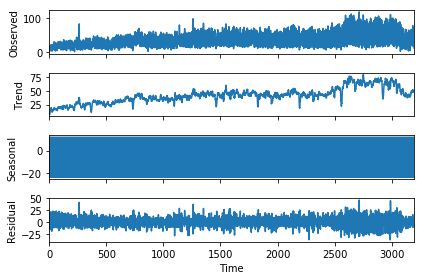

In [36]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df['y'].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

In [37]:
train_df.index = pd.to_datetime(train_df.index)

Оптимальный параметр преобразования Бокса-Кокса: 0.415948
Критерий Дики-Фуллера: p=0.040528


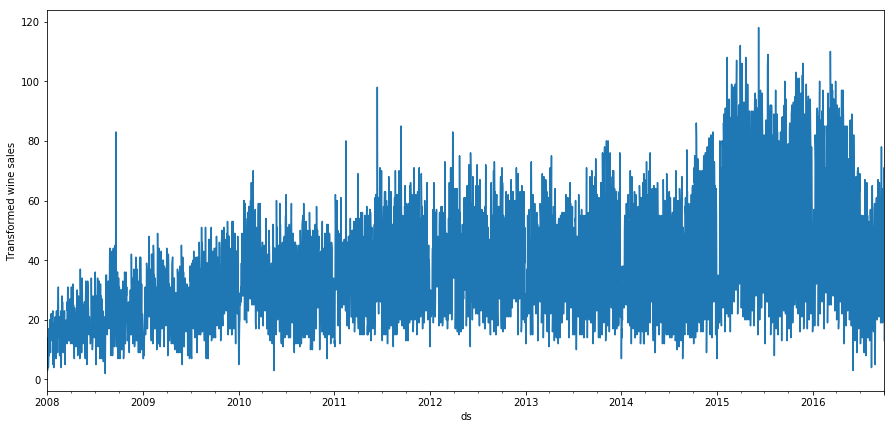

In [38]:
train_df['y_box'], lmbda = stats.boxcox([1 if x == 0 else x for x in train_df['y']])
plt.figure(figsize=(15,7))
train_df.y.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

Критерий Дики-Фуллера: p=0.000000


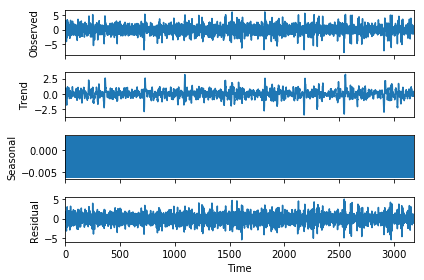

In [39]:
train_df['y_box_diff'] = train_df.y_box - train_df.y_box.shift(7)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(train_df.y_box_diff[12:].values, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(train_df.y_box_diff[8:])[1])

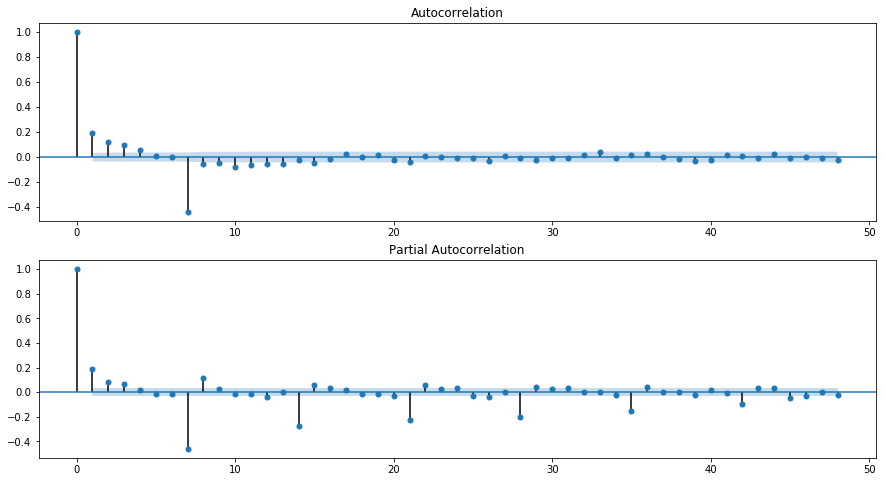

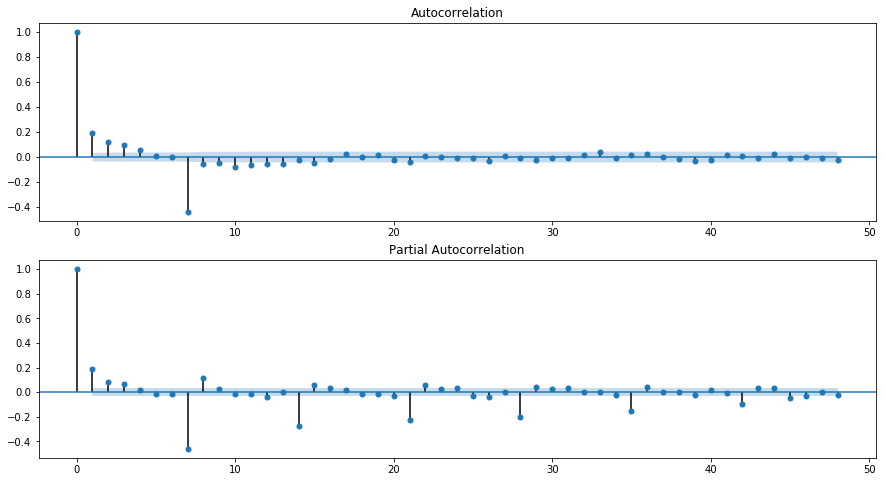

In [40]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_box_diff[13:].values.squeeze(), lags=48, ax=ax)

Начальные приближения Q = 1, q = 4, P = 5, p = 3

In [41]:
ps = range(0, 4)
d=1
qs = range(0, 5)
Ps = range(0, 7)
D=1
Qs = range(0, 2)

In [42]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

280

In [43]:
%%time
results = []
best_aic = float("inf")



for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        %time model=sm.tsa.statespace.SARIMAX(train_df.y_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
wrong parameters: (0, 0, 0, 0)
(0, 0, 0, 1)
Wall time: 830 ms
(0, 0, 1, 0)
Wall time: 672 ms
(0, 0, 1, 1)
Wall time: 978 ms
(0, 0, 2, 0)
Wall time: 870 ms
(0, 0, 2, 1)
Wall time: 1.63 s
(0, 0, 3, 0)
Wall time: 1.27 s
(0, 0, 3, 1)
Wall time: 3.08 s
(0, 0, 4, 0)
Wall time: 1.88 s
(0, 0, 4, 1)
Wall time: 6.51 s
(0, 0, 5, 0)
Wall time: 2.78 s
(0, 0, 5, 1)
Wall time: 9.54 s
(0, 0, 6, 0)
Wall time: 3.84 s
(0, 0, 6, 1)
Wall time: 14.6 s
(0, 1, 0, 0)
Wall time: 1.3 s
(0, 1, 0, 1)
Wall time: 1.07 s
(0, 1, 1, 0)
Wall time: 797 ms
(0, 1, 1, 1)
Wall time: 1.19 s
(0, 1, 2, 0)
Wall time: 1.17 s
(0, 1, 2, 1)
Wall time: 2.31 s
(0, 1, 3, 0)
Wall time: 1.87 s
(0, 1, 3, 1)
Wall time: 4.86 s
(0, 1, 4, 0)
Wall time: 2.95 s
(0, 1, 4, 1)
Wall time: 10.1 s
(0, 1, 5, 0)
Wall time: 4.34 s
(0, 1, 5, 1)
Wall time: 13.6 s
(0, 1, 6, 0)
Wall time: 5.85 s
(0, 1, 6, 1)
Wall time: 19.7 s
(0, 2, 0, 0)
Wall time: 1.95 s
(0, 2, 0, 1)
Wall time: 1.53 s
(0, 2, 1, 0)
Wall time: 3.16 s
(0, 2, 1, 1)
Wall time: 1.8

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 4.07 s
(0, 3, 0, 1)
Wall time: 2.19 s
(0, 3, 1, 0)
Wall time: 6.21 s
(0, 3, 1, 1)
Wall time: 4.07 s
(0, 3, 2, 0)
Wall time: 10.3 s
(0, 3, 2, 1)
Wall time: 5.15 s
(0, 3, 3, 0)
Wall time: 15.5 s
(0, 3, 3, 1)
Wall time: 11.3 s
(0, 3, 4, 0)
Wall time: 6.21 s
(0, 3, 4, 1)
Wall time: 31.9 s
(0, 3, 5, 0)
Wall time: 5.72 s
(0, 3, 5, 1)
Wall time: 24.1 s
(0, 3, 6, 0)
Wall time: 9.05 s
(0, 3, 6, 1)
Wall time: 40.1 s
(0, 4, 0, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 4.65 s
(0, 4, 0, 1)
Wall time: 4.37 s
(0, 4, 1, 0)
Wall time: 5.35 s
(0, 4, 1, 1)
Wall time: 3.35 s
(0, 4, 2, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 15.5 s
(0, 4, 2, 1)
Wall time: 6.88 s
(0, 4, 3, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 31.6 s
(0, 4, 3, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 16 s
(0, 4, 4, 0)
Wall time: 40.7 s
(0, 4, 4, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 38.2 s
(0, 4, 5, 0)
Wall time: 1min 32s
(0, 4, 5, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 1min 25s
(0, 4, 6, 0)
Wall time: 2min 20s
(0, 4, 6, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 1min 6s
(1, 0, 0, 0)
Wall time: 674 ms
(1, 0, 0, 1)
Wall time: 968 ms
(1, 0, 1, 0)
Wall time: 763 ms
(1, 0, 1, 1)
Wall time: 1.1 s
(1, 0, 2, 0)
Wall time: 1.01 s
(1, 0, 2, 1)
Wall time: 2 s
(1, 0, 3, 0)
Wall time: 1.58 s
(1, 0, 3, 1)
Wall time: 3.74 s
(1, 0, 4, 0)
Wall time: 2.65 s
(1, 0, 4, 1)
Wall time: 7.65 s
(1, 0, 5, 0)
Wall time: 3.46 s
(1, 0, 5, 1)
Wall time: 10.6 s
(1, 0, 6, 0)
Wall time: 5.09 s
(1, 0, 6, 1)
Wall time: 17.5 s
(1, 1, 0, 0)
Wall time: 1.58 s
(1, 1, 0, 1)
Wall time: 1.53 s
(1, 1, 1, 0)
Wall time: 2.13 s
(1, 1, 1, 1)
Wall time: 1.72 s
(1, 1, 2, 0)
Wall time: 5.55 s
(1, 1, 2, 1)
Wall time: 3.09 s
(1, 1, 3, 0)
Wall time: 10.5 s
(1, 1, 3, 1)
Wall time: 5.36 s
(1, 1, 4, 0)
Wall time: 4.36 s
(1, 1, 4, 1)
Wall time: 13.9 s
(1, 1, 5, 0)
Wall time: 5.56 s
(1, 1, 5, 1)
Wall time: 18.4 s
(1, 1, 6, 0)
Wall time: 7.96 s
(1, 1, 6, 1)
Wall time: 27.7 s
(1, 2, 0, 0)
wrong parameters: (1, 2, 0, 0)
(1, 2, 0, 1)
wrong parameters: (1, 2, 0, 1)
(1, 2, 1, 0)
wrong parameters

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 5.39 s
(1, 4, 0, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 6.14 s
(1, 4, 1, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 6.03 s
(1, 4, 1, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 6.94 s
(1, 4, 2, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 14.6 s
(1, 4, 2, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 11.9 s
(1, 4, 3, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 24.5 s
(1, 4, 3, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 18.6 s
(1, 4, 4, 0)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 1min 2s
(1, 4, 4, 1)


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Wall time: 40.9 s
(1, 4, 5, 0)


KeyboardInterrupt: 

In [44]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters          aic
58   (0, 4, 1, 1)  9630.202657
100  (1, 4, 1, 1)  9630.261995
62   (0, 4, 3, 1)  9630.477718
60   (0, 4, 2, 1)  9631.849555
64   (0, 4, 4, 1)  9632.118207


In [45]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             y_box   No. Observations:                 3197
Model:             SARIMAX(0, 1, 4)x(1, 1, 1, 7)   Log Likelihood               -4808.101
Date:                           Sat, 11 Nov 2017   AIC                           9630.203
Time:                                   00:47:55   BIC                           9672.692
Sample:                               01-01-2008   HQIC                          9645.437
                                    - 10-01-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8194      0.018    -44.919      0.000      -0.855      -0.784
ma.L2         -0.1293      0.022     -5.990

Критерий Стьюдента: p=0.177228
Критерий Дики-Фуллера: p=0.000000


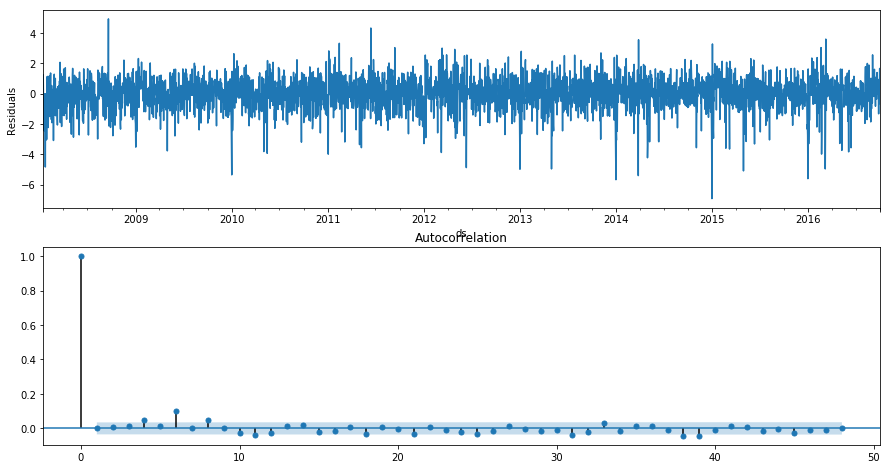

In [46]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

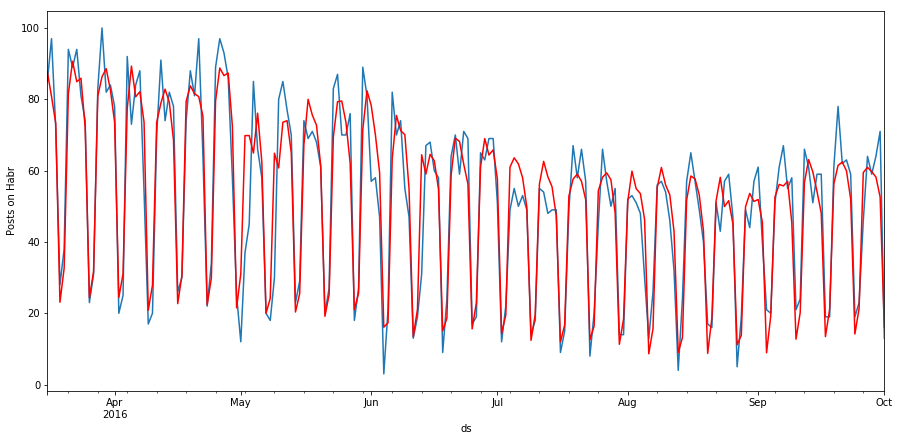

In [47]:
train_df['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
train_df.y.tail(200).plot()
train_df.arima_model[13:].tail(200).plot(color='r')
plt.ylabel('Posts on Habr');

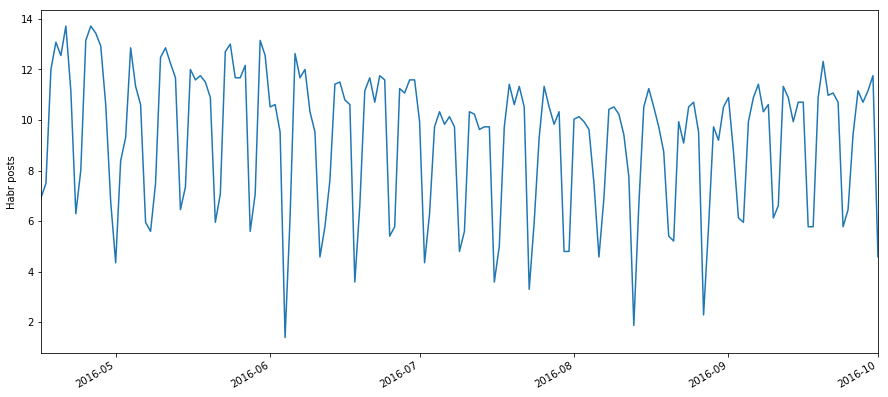

In [48]:
arima_df = train_df2.set_index('ds')[['y']]

date_list = [pd.datetime.strptime("2016-10-01", "%Y-%m-%d") + 
             pd.Timedelta(x) for x in range(0, predictions+1)]
future = pd.DataFrame(index=date_list, columns= arima_df.columns)
arima_df = pd.concat([arima_df, future])
arima_df['forecast'] = invboxcox(best_model.predict(start=train_df.shape[0], end=train_df.shape[0]+predictions-1), lmbda)
plt.figure(figsize=(15,7))
arima_df.y.tail(200).plot()
arima_df.forecast.tail(200).plot(color='r')
plt.ylabel('Habr posts');

In [49]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2008-01-01,18.538028,4.512242,33.416146,3.0,-15.538028,-517.934278
2008-01-02,16.379236,1.361193,31.790855,3.0,-13.379236,-445.974539
2008-01-03,15.022891,-0.135412,28.982428,4.0,-11.022891,-275.572263
2008-01-04,11.239579,-2.711434,25.128572,14.0,2.760421,19.717296
2008-01-05,-16.598180,-31.474307,-2.522454,4.0,20.598180,514.954490


In [50]:
cmp_df = cmp_df.join(arima_df[['forecast']])

In [51]:
import numpy as np
cmp_df['e_arima'] = cmp_df['y'] - cmp_df['forecast']
cmp_df['p_arima'] = 100*cmp_df['e_arima']/cmp_df['y']

In [52]:
num_values = 200

forecast = go.Scatter(
    name='Prophet',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).yhat,
    mode='lines',
    line=dict(color='rgb(31, 119, 180)'),
)


fact = go.Scatter(
    name='Fact',
    x=cmp_df.tail(num_values).index,
    y=cmp_df.tail(num_values).y,
    marker=dict(color="red"),
    mode='lines',
)

arima = go.Scatter(
    name='ARIMA',
    x=cmp_df.tail(predictions).index,
    y=cmp_df.tail(predictions).forecast,
    mode='lines'
)

# Trace order can be important
# with continuous error bars
data = [forecast, fact, arima]

layout = go.Layout(
    yaxis=dict(title='Посты'),
    title='Опубликованные посты на Хабрахабре',
    showlegend = True)

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)